In [1]:
from ndslib.config import jupyter_startup
jupyter_startup()

# Hide that we are repeating some code from the last chapter:
from ndslib.data import load_data
abide_data = load_data("abide2")
features = abide_data.filter(like='fs')
phenotypes = abide_data.iloc[:, :6]
y = phenotypes['age']

(ml-overfitting)=
# Overfitting

Let's pause and take stock of our progress. In the last section, we developed
three fully operational machine-learning workflows: one for regression, one for
classification, and one for clustering. Thanks to Scikit-learn, all three
involved very little work. In each case, it took only a few lines of code to
initialize a model, fit it to some data, and use it to generate predictions or
assign samples to clusters. This all seems pretty great. Maybe we should just
stop here, pat ourselves on the back for a job well done, and head home for the
day satisfied with the knowledge we've become proficient machine learners.

While a brief pat on the back does seem appropriate, we probably shouldn't be
*too* pleased with ourselves. We've learned some important stuff, yes, but a
little bit of knowledge can be a dangerous thing. We haven't yet touched on some
concepts and techniques that are critical if we want to avoid going off the
rails with the skills we've just acquired. And going off the rails, as we'll
see, is surprisingly easy.

To illustrate just *how* easy, let's return to our brain-age prediction example.
Recall that when we fitted our linear regression model to predict age from our
brain features, we sub-sampled only a small number of features (5, to be exact).
We found that, even with just 5 features, our model was able to capture a
non-trivial fraction of the variance in age—about 20%. Intuitively, you might
find yourself thinking something like this: *if we did that well with just 5 out
of 1,440 features selected at random, imagine how well we might do with more
features!* And you might be tempted to go back to the model-fitting code,
replace the `n_features` variable with some much larger number, re-run the code,
and see how well you do.

Let's go ahead and give in to that temptation. In fact, let's give in to
temptation systematically. We'll re-fit our linear regression model with random
feature subsets of different sizes and see what effect that has on performance.
We start by setting up the size of the feature sets. We will run this 10 times
in each set size, so we can average and get more stable results.

In [2]:
n_features = [5, 10, 20, 50, 100, 200, 500, 1000, 1440]
n_iterations = 10

We initialize a placeholder for the results and extract the age phenotype,
which we will use in all of our model fits.

In [3]:
import numpy as np
results = np.zeros((len(n_features), n_iterations))

Looping over feature set sizes and iterations, we sample features, fit a model, and
save the score into the `results` array.

In [4]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

for i, n in enumerate(n_features):
    for j in range(n_iterations):
        X = features.sample(n, axis=1)
        model.fit(X, y)
        results[i, j] = model.score(X, y)

Let's plot the observed $R^2$ as a function of the number of predictors. We'll
plot a dark line for the averages across iterations and use Matplotlib's
`fill_between` function to add 1 standard deviation error bars, even though
these will be so small that they are hard to see.

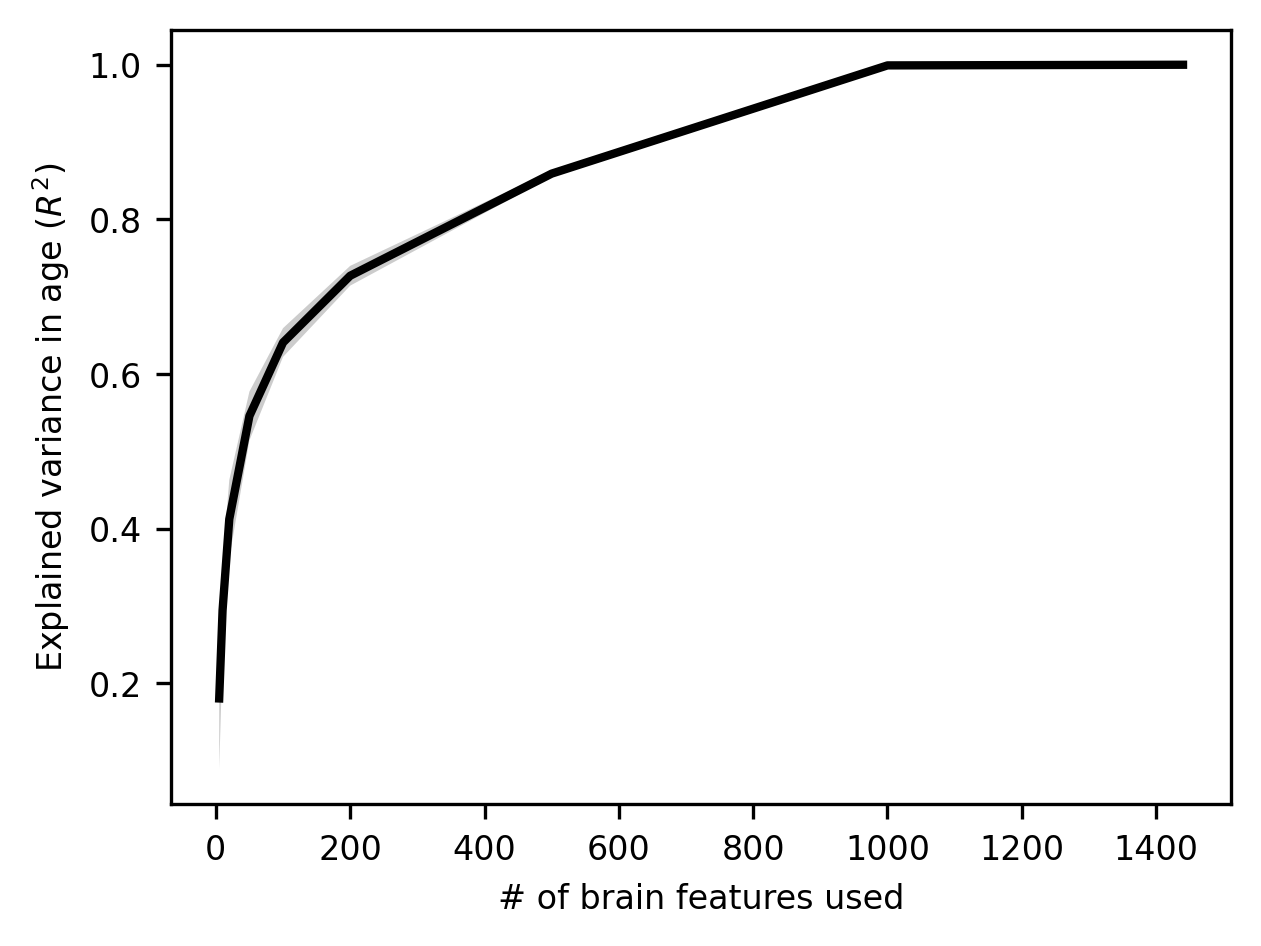

In [5]:
import matplotlib.pyplot as plt

averages = results.mean(1)

fig, ax = plt.subplots()
ax.plot(n_features, averages, linewidth=2)
stds = results.std(1)
ax.fill_between(n_features, averages - stds, averages + stds, alpha=0.2)

ax.set_xlabel("# of brain features used")
ax.set_ylabel("Explained variance in age ($R^2$)");

At first glance, this might look great: performance improves rapidly with the
number of features, and by the time we're sampling 1,000 features, we can
predict age perfectly! But a truism in machine learning (and in life more
generally) is that if something seems too good to be true, it probably is.

In this case, a bit of reflection on the fact that our model seems able to
predict age with zero error should set off all kinds of alarm bells, because, on
any reasonable understanding of how the world works, such a thing should be
impossible. Set aside the brain data for a moment and just think about the
problem of measuring chronological age. Is it plausible to think that, in a
sample of over 1,000 people, including many young children and older adults, not
a single person's age would be measured with even the slightest bit of error?
Remember, *any* measurement error should reduce our linear regression model's
performance because measurement error is irreducible. If an ABIDE-II
participant's birth date happened to be recorded as 1971 when it's really 1961
(oops, typo!), it's not as if our linear regression model can somehow learn to
go back in time and adjust for that error.

Then think about the complexity of the brain-derived features we're using; how
well (or poorly) *those* features are measured/extracted; how simple our linear
regression model is; and how much opportunity there is for all kinds of data
quality problems to arise (is it plausible to think that all subjects' scans are
of good enough quality to extract near-perfect features?). If you spend a couple
of minutes thinking along these lines, it should become very clear that an $R^2$
of 1.0 for a problem like this is just not remotely believable. There must be
something very wrong with our model. And there is: our model is *overfitting*
our data. Because we have a lot of features to work with -- even more than
samples, our linear regression model is, in a sense getting creative: it's
finding all kinds of patterns in the data that look like they're there but
aren't. We'll spend the rest of this section exploring this idea and unpacking
its momentous implications.

## Understanding overfitting

To better understand overfitting, let's set aside our relatively complex
neuroimaging dataset for the moment and work with some simpler examples.

Let's start by sampling some data from a noisy function where the underlying functional form is quadratic. We'll create a small function for the data generation so that we can reuse this code later on.

In [6]:
def make_xy(n, sd=0.5):
    ''' Generate x and y variables from a fixed quadratic function,
    adding noise. '''
    x = np.random.normal(size=n)
    y = (0.7 * x) ** 2 + 0.1 * x + np.random.normal(10, sd, size=n)
    return x, y

We fix the seed for the generation of random numbers and then produce some data and visualize it.

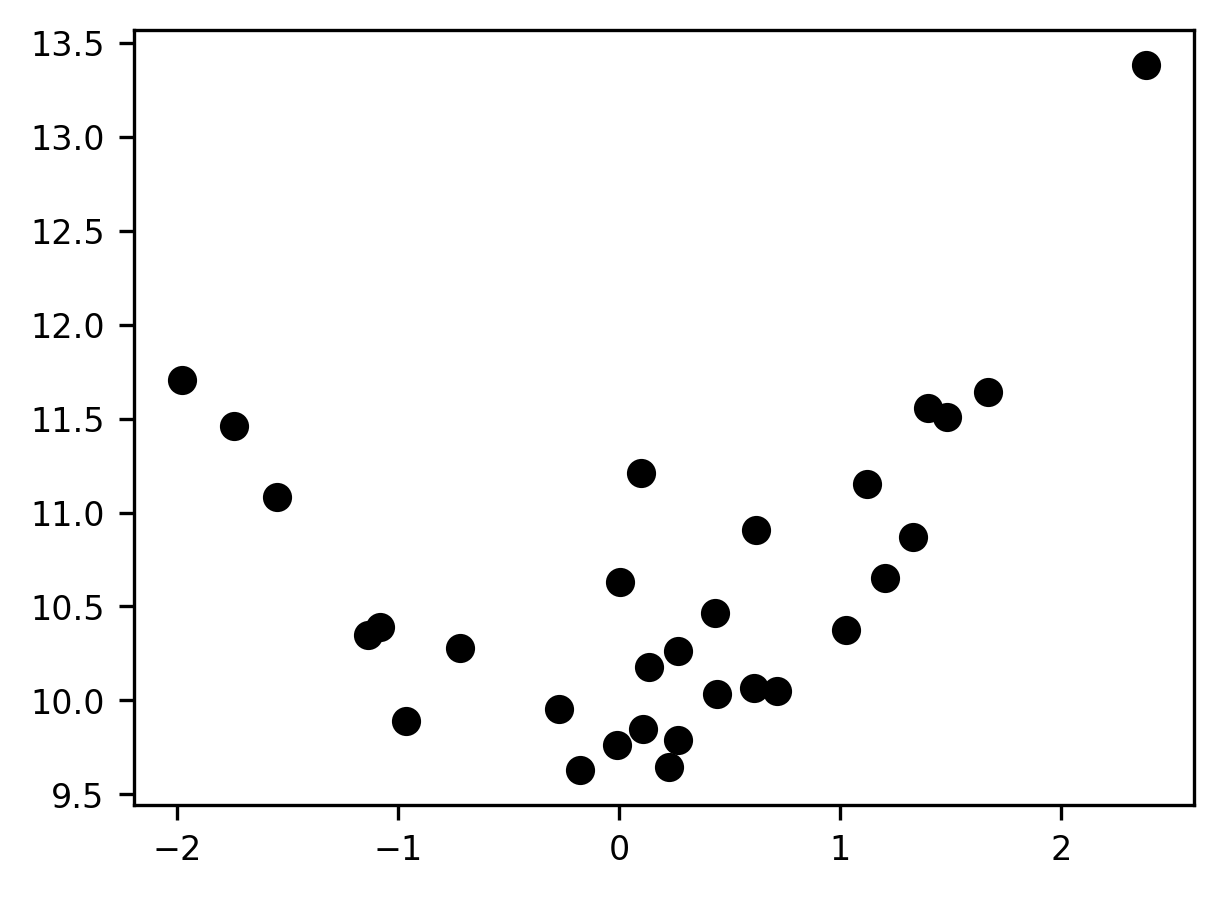

In [7]:
np.random.seed(10)

x, y = make_xy(30)

fig, ax = plt.subplots()
p = ax.scatter(x, y)

### Fitting data with models of different flexibility

Now let's fit that data with a linear model. To visualize the results of the linear model, we will use the model that has been fit to the data to predict the values of a range of values similar to the values of `x`.

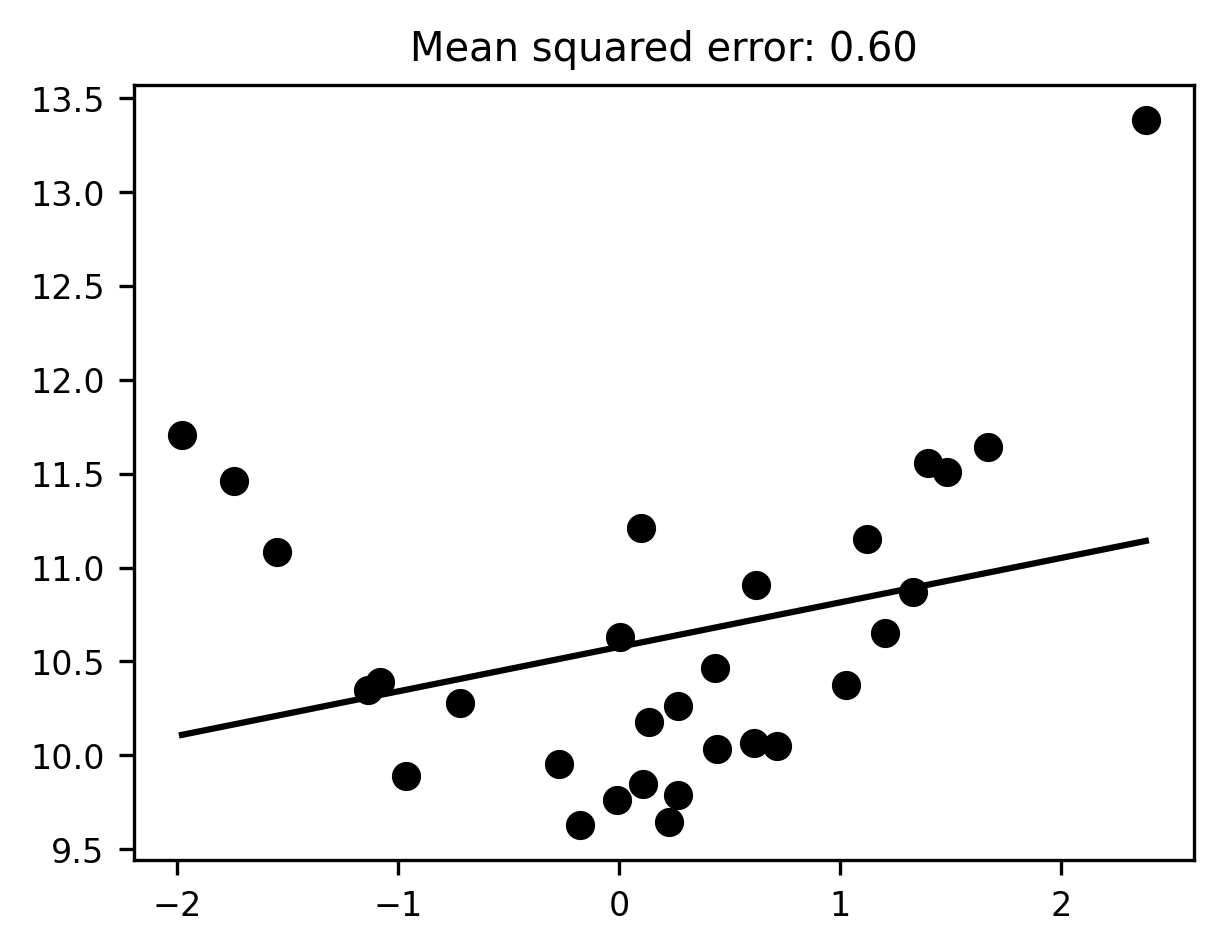

In [8]:
from sklearn.metrics import mean_squared_error

est = LinearRegression()
est.fit(x[:, None], y)

x_range = np.linspace(x.min(), x.max(), 100)
reg_line = est.predict(x_range[:, None])

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x_range, reg_line);
mse = mean_squared_error(y, est.predict(x[:, None]))
ax.set_title(f"Mean squared error: {mse:.2f}");

The fit looks... meh. It seems pretty clear that our linear regression model is *under*fitting the data—meaning, there are clear patterns in the data that the fitted model fails to describe.

What can we do about this? Well, the problem here is that our model is insufficiently flexible; our straight regression line can't bend itself to fit the contours of the observed data. The solution is to use a more flexible estimator! A linear fit won't cut it —- we need to fit *curves*.

Just to make sure we don't underfit again, let's use a much more flexible estimator -— specifically, a 10th-degree polynomial regression model.

This is also a good opportunity to introduce a helpful object in Scikit-learn called a `Pipeline`. The idea behind a `Pipeline` is that we can stack several transformation steps together in a sequence, and then cap them off with an `Estimator` of our choice. The whole pipeline will then behave like a single `Estimator` -- i.e., we only need to call `fit()` and `predict()` once.

```{eval-rst}
.. index::
   single: Scikit-learn Pipelines
```

Using a pipeline will allow us to introduce a preprocessing step before the
LinearRegression model receives our data, in which we create a bunch of
polynomial features (by taking $x^2$, $x^3$, $x^4$, and so on—all the way up to
$x^{10}$). We'll make use of Scikit Learn's handy `PolynomialFeatures`
transformer, which is implemented in the `preprocessing` module.


```{eval-rst}
.. index::
   single: Polynomial features
```

We'll create a function that wraps the code to generate the pipeline, so
that we can reuse that as well.

In [9]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

def make_pipeline(degree=1):
    """Construct a Scikit Learn Pipeline with polynomial features and linear regression """
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)

    pipeline = Pipeline([
        ("polynomial_features", polynomial_features),
        ("linear_regression", LinearRegression())
    ])
    return pipeline

Now we can initialize a pipeline with `degree=10`, and fit it to our toy data:

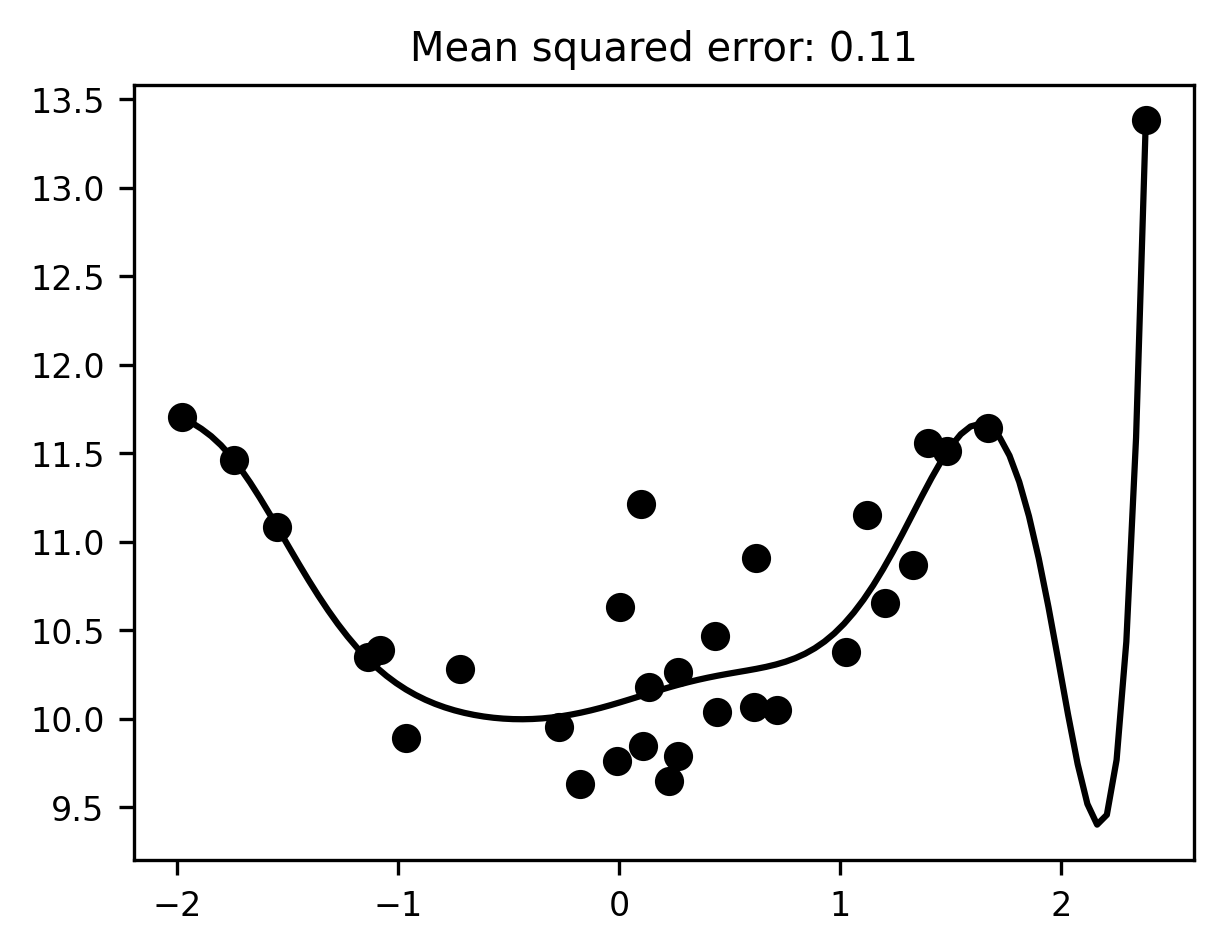

In [10]:
degree = 10
pipeline = make_pipeline(degree)
pipeline.fit(x[:, None], y)
reg_line = pipeline.predict(x_range[:, None])

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x_range, reg_line)
mse = mean_squared_error(y, pipeline.predict(x[:, None]))
ax.set_title(f"Mean squared error: {mse:.2f}");

At first blush, this model seems to fit the data much better than the first
model, in the sense that it reduces the mean squared error considerably relative
to the simpler linear model (our MSE went down from 0.6 to 0.11). But, much as
it seemed clear that the previous model was *under*fitting, it should now be
intuitively obvious that the 10th-degree polynomial model is *over*fitting. The
line of best fit plotted above has to bend in some fairly unnatural ways to capture individual data points. While this helps reduce the error for
these particular data, it's hard to imagine that the same line would still be
very close to the data if we sampled from the same distribution a second or
third time.

We can test this intuition by doing exactly that: we sample some more data from
the same process and see how well our fitted model predicts the new scores.

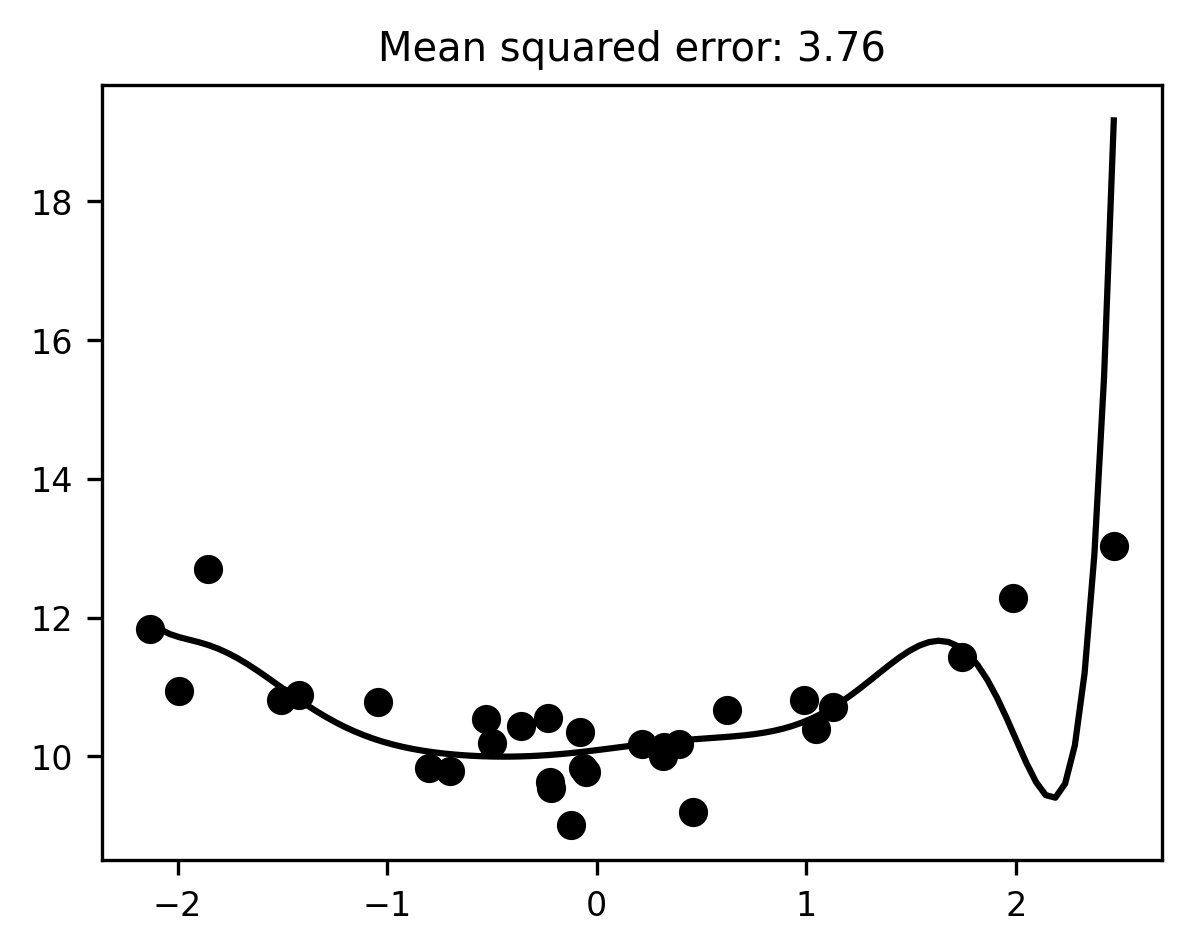

In [11]:
test_x, test_y = make_xy(30)

x_range = np.linspace(test_x.min(), test_x.max(), 100)
reg_line = pipeline.predict(x_range[:, None])

fig, ax = plt.subplots()
ax.scatter(test_x, test_y)
ax.plot(x_range, reg_line)

mse = mean_squared_error(y, pipeline.predict(test_x[:, None]))
ax.set_title(f"Mean squared error: {mse:.2f}");

That's... not good. When we apply our overfitted model to new data, the mean
squared error skyrockets. The model performs significantly worse than even our
underfitting linear model did.

(ml-overfitting_ex1)=
#### Exercise

Apply the linear model to new data in the same manner. Does the linear model's
error also increase when applied to new data? Is this increase smaller or larger
than what we observe for our 10th-order polynomial model?

Of course, since we wrote the data-generating process ourselves, and hence know
the ground truth, we may as well go ahead and fit the data with the true
functional form, which in this case is a polynomial with degree 2:

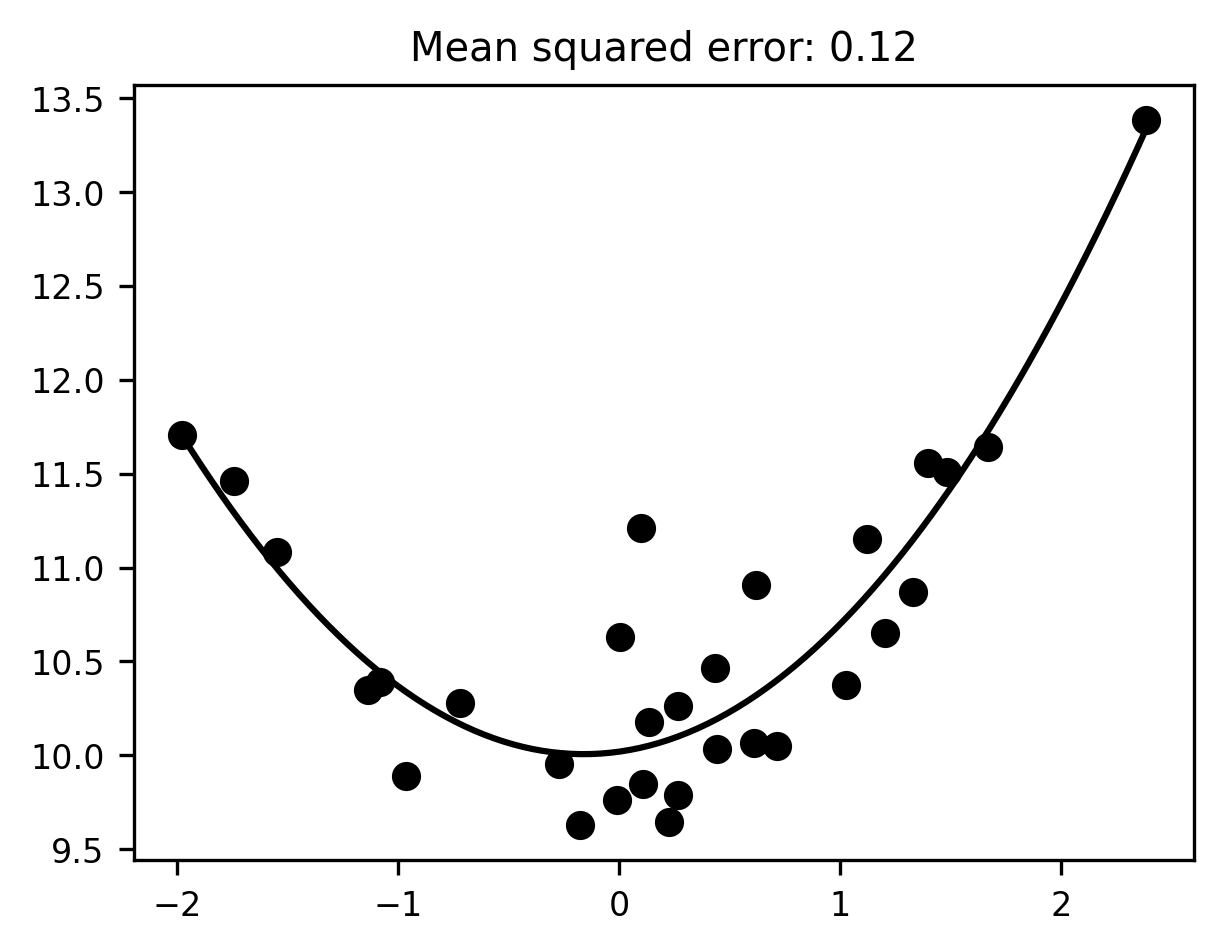

In [12]:
degree = 2
pipeline = make_pipeline(degree)
pipeline.fit(x[:, None], y)
x_range = np.linspace(x.min(), x.max(), 100)
reg_line = pipeline.predict(x_range[:, None])

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x_range, reg_line)
mse = mean_squared_error(y, pipeline.predict(x[:, None]))
ax.set_title(f"Mean squared error: {mse:.2f}");

There, that looks much better. Unfortunately, in the real world, we don't
usually know the ground truth. If we did, we wouldn't have to fit a model in the
first place! So we're forced to navigate between the two extremes of overfitting
and underfitting in some other way. Finding this delicate balance is one of the
central problems of machine learning -— perhaps *the* central problem. For any
given dataset, a more flexible model will be able to capture more nuanced,
subtle patterns in the data. The cost of flexibility, however, is that such a
model is also more likely to fit patterns in the data that are only there
because of noise, and hence won't generalize to new samples. Conversely, a less
flexible model is only capable of capturing simple patterns in the data. This
means it will avoid chasing down rabbit holes full of spurious patterns, but it
does so at the cost of missing out on a lot of real patterns too.

One way to think about this is that, as a data scientist, the choice you face is
seldom between good models and bad ones. but rather, between lazy and energetic
ones (later on, we'll also see that there are many different ways to be lazy or
energetic). The simple linear model we started with is relatively lazy: it has
only one degree of freedom to play with.

The 10th-degree polynomial, by contrast, is hyperactive and sees patterns
everywhere, and if it has to go very far out of its way to fit a data point
that's giving it particular trouble, it'll happily do that.

Getting it right in any given situation requires you to strike a balance between
these two extremes. Unfortunately, the precise point of optimality varies on a
case-by-case basis. Later on, we'll connect the ideas of overfitting vs.
underfitting (or, relatedly, flexibility vs. stability) to another key concept
-— the *bias-variance tradeoff*. But first, let's turn our attention next to
some of the core methods machine learners use to diagnose and prevent
overfitting.

### Additional resources

In case you are wondering whether overfitting happens in real research
you should read the paper "I tried a bunch of things: The dangers of unexpected
overfitting in classification of brain data" by Mahan Hosseini and colleagues
{cite}`Hosseini2020-uc`. It nicely demonstrates how easy it is to fall into the
trap of overfitting when doing data analysis on large complex datasets, and
offers some rigorous approaches to help mitigate this risk.